In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50


In [4]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
# Preprocessing and data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [6]:
# Split dataset
train_ds = dataset.take(int(0.8 * len(dataset))).cache().shuffle(1000).map(lambda x, y: (data_augmentation(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = dataset.skip(int(0.8 * len(dataset))).take(int(0.1 * len(dataset))).cache().shuffle(1000).map(lambda x, y: (data_augmentation(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = dataset.skip(int(0.9 * len(dataset))).cache().shuffle(1000).map(lambda x, y: (data_augmentation(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

# Load pre-trained VGG19 model
base_model = tf.keras.applications.VGG19(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
                                         include_top=False,
                                         weights='imagenet')

In [7]:
# Freeze convolutional base
base_model.trainable = False

In [8]:
# Add custom classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(dataset.class_names), activation='softmax')

# Build the model
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/50


54/54 [==============================] - 163s 3s/step - loss: 0.9276 - accuracy: 0.5700 - val_loss: 0.7813 - val_accuracy: 0.6927
Epoch 2/50
54/54 [==============================] - 159s 3s/step - loss: 0.7619 - accuracy: 0.7604 - val_loss: 0.6772 - val_accuracy: 0.8229
Epoch 3/50
54/54 [==============================] - 159s 3s/step - loss: 0.6859 - accuracy: 0.8212 - val_loss: 0.6143 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 158s 3s/step - loss: 0.6280 - accuracy: 0.8362 - val_loss: 0.5710 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 159s 3s/step - loss: 0.5834 - accuracy: 0.8455 - val_loss: 0.5339 - val_accuracy: 0.8490
Epoch 6/50
54/54 [==============================] - 159s 3s/step - loss: 0.5480 - accuracy: 0.8455 - val_loss: 0.5000 - val_accuracy: 0.8854
Epoch 7/50
54/54 [==============================] - 161s 3s/step - loss: 0.5104 - accuracy: 0.8524 - val_loss: 0.4568 - val_accuracy: 0.8646
Epoch 8/50


In [15]:
# Evaluate the model on test data
scores = model.evaluate(test_ds)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

7/7 [==============================] - 17s 2s/step - loss: 0.1924 - accuracy: 0.9500
Test Loss: 0.19241099059581757
Test Accuracy: 0.949999988079071


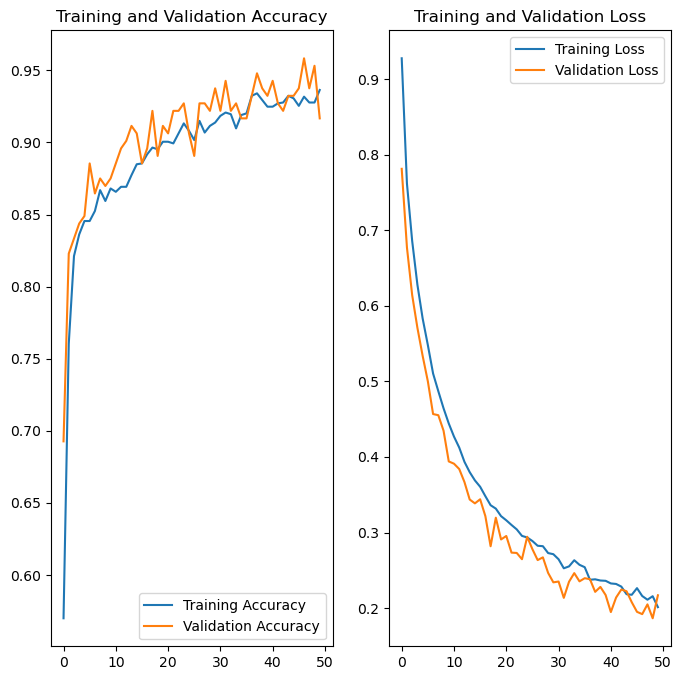

In [13]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

7/7 [==============================] - 17s 2s/step


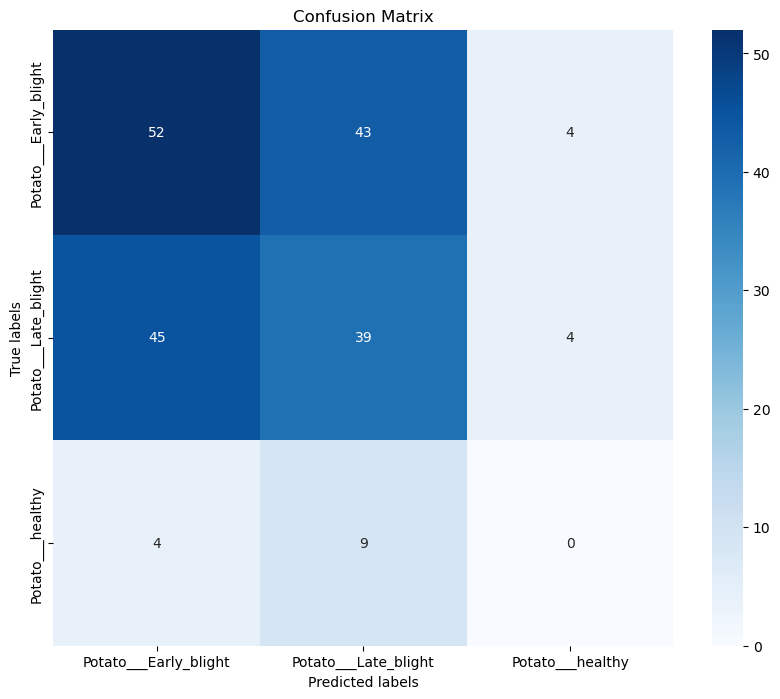

In [14]:
# Confusion Matrix
y_test = np.concatenate([y for _, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=-1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.class_names, yticklabels=dataset.class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()